In [1]:
from toolz import curry

import pandas as pd
import numpy as np
from scipy.special import expit

from linearmodels.panel import PanelOLS
import statsmodels.formula.api as smf

import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import style

style.use("ggplot")

# Difference-in-Diferences: Death and Rebirth


## The Promise of Panel Data


Panel data is when we have multiple units `i` over multiple periods of time `t`. Think about a policy evaluation scenario in the US, where you want to check the effect of cannabis legalization on crime rate. You have crime rate data on multiple states `i` over multiple time perios `t`. You also observe at what point in time each state adopts legislation in the direction of canabis legalization. I hope you can see why this is incredibly powerfull for causal inference. Call canabis legalization the treatment `D` (since `T` is taken; it represents time). We can follow the trend on crime rates for a particular state that eventually gets treated and see if there are any disruptions in the trend at the treatment time. In a way, a state serves as its own control unit, in a sort of before and after comparisson. Furthermore, becase we have multiple states, we can also compare treated states to control states. When we put both comparissons toguether, treated vs control and before and after treatement, we end up with an incredibly powerfull tool to infer counterfactuals and, hence, causal effects. 

Panel data methods are often used in govenment policy evaluation, but we can easily make an argument about why it is also incredibly usefull for the (tech) industry. Companies often track user data across multiple periods of time, which results in a rich panel data structure. To expore that idea further, let's consider a hypothetical example of a tech company that traked customers for multiple years. Along those years, it rolled out a new product for some of its customers. More specifically, some customers got acess to the new product in 1985, others in 1994 and others in the year 2000. In causal infererence terms, we can already see that the new product can be seen as a treatment. We call each of those **groups of customers that got treated at the same time a cohort**. In this hypothetical exemple, we want to figure out the impact of the new product on sales. The folowing image shows how sales evolve over time for each of the treated cohorts, plus a never treated group of customers. 

In [2]:
time = range(1980, 2010)
cohorts = [1985,1994,2000,2011]
units = range(1, 100+1)

np.random.seed(1)

df_hom_effect = pd.DataFrame(dict(
    year = np.tile(time, len(units)),
    unit = np.repeat(units, len(time)),
    cohort = np.repeat(np.random.choice(cohorts, len(units)), len(time)),
    unit_fe = np.repeat(np.random.normal(0, 5, size=len(units)), len(time)),
    time_fe = np.tile(np.random.normal(size=len(time)), len(units)),
)).assign(
    trend = lambda d: (d["year"] - d["year"].min())/8,
    post = lambda d: (d["year"] >= d["cohort"]).astype(int),
).assign(
    treat = 1,
    y0 = lambda d: 10 + d["trend"] + d["unit_fe"] + 0.1*d["time_fe"],
).assign(
    treat_post = lambda d: d["treat"]*d["post"],
    y1 = lambda d: d["y0"] + 1
).assign(
    tau = lambda d: d["y1"] - d["y0"],
    sales = lambda d: np.where(d["treat_post"] == 1, d["y1"], d["y0"])
).drop(columns=["unit_fe", "time_fe", "trend", "y0", "y1"])

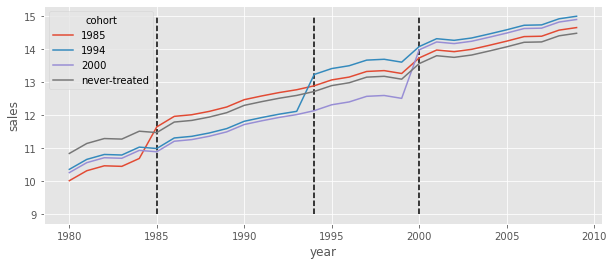

In [3]:
plt.figure(figsize=(10,4))
[plt.vlines(x=c, ymin=9, ymax=15, color="black", ls="dashed") for c in cohorts[:-1]]
sns.lineplot(
    data=(df_hom_effect
          .replace({"cohort":{2011:"never-treated"}})
          .groupby(["cohort", "year"])["sales"]
          .mean()
          .reset_index()),
    x="year",
    y = "sales",
    hue="cohort",
);

Let's take a momen to appreciate the richness of the data depicted in the above plot. First, we can see that each cohorts have its own baseline level. Thats simply because different customers buy different ammounts. For instance, it looks like customers in the never treated cohort have a higher baseline (of about 11), compared to other cohorts. This means that simply comparing treated cohorts to control cohorts would yield a biased result, since $Y_{0}$ for the neve treated is higher than the $Y_{0}$ for the treated. Fortunatly, we can compare acorss units and time.

Speaking of time, notice how there is an overall upward trend with some wigles (for example, there is a dip in the year 1999). Since latter years have higher $Y_{0}$ than early years, simply comparing the same unit across time would also yield in biased results. Once again, we are fortunate that the pannel data structure allow us to compare not only across time, but also across units. 

Another way to see the power of panel data structure in through the lens of linear models and linear regression. Let's say each of our customers `i` has a spend propensity $\gamma$. This is because of indosincasies due to stuff we can't observe, like customer's salary, family sinze and so on. Also, we can say that each year has an sales level $\theta$. Again, maibe because there is a crisis in one year, sales drop. If that is the case, a good way of modeling sales is to say it depends on the customer effect $\gamma$ and the time effect $\theta$, plus some random noise.

$$
Sales_{it} = \gamma_i + \theta_t + e_{it}
$$

To include the treatment in this picture, lets define a variable $D_{it}$ wich is 1 if the unit is treated. In our example, this variable would be always zero for the never treated cohort. It would also be zero for all the other cohorts at the begining, but it would turn into 1 at year 1985 for the cohort treated in 1985 and stay on after that. Same thing for other cohorts, it would turn into 1 at 1994 fot the cohort treated in 1994 and so on. We can include in our model of sales as follows:

$$
Sales_{it} = \tau D_{it} + \gamma_i + \theta_t + e_{it}
$$

Estimating the above model is OLS is what is called the Two-Way Fixed Effects Models (TWFE). Notice that $\tau$ would be the treatment effect, as it tells us how much sales changes once units are treated. Another way of looking at it is to invoke the "holding things constant" propriety of linear regression. If we estimate the above model, we could read the estimate of $\tau$ as how much sales would change if we flip the treatment from 0 to 1 while holding the unit `i` and time `t` fixed. Take a minute to appriciate how bold this is! To say we would hold each unit fixed while seeng how $D$ changes the outcome is to say we are controling for all unit specific characteristic, known and unknown. For example, we would be controling for customers past sales, wich we could measure, but also stuff we have no idea about, like how much the customer like our brand, his salary... The only requirement is that this caracteristic is fixed over the time of the analysis. Moreover, to say we would hold each time period fixed is to say we are controlling for all year specifit characteristic. For instance, since we are holding year fixed, while looking at the effect of $D$, that trend over there would vanish.


To see all this power in action all we have to do is run an OLS model with the treatment indicator $D$ (`treat_post` here), plut dummies for the units and time. In our particular example, I've generated data in such a way that the effect of the treatment (new product) is to increase sales by 1. Notice how TWFE nais in recovering that treatment effect

In [4]:
formula = f"""sales ~ treat_post + C(unit) + C(year)"""

mod = smf.ols(formula, data=df_hom_effect)

result = mod.fit()

result.params["treat_post"]

0.9999999999999956

Since I've simulated the data above, I know exactly the true individual treatment effect, which is stored in the `tau` column. Since the TWFE recovers the treatment effect on the treated, we can verify that the true ATT matches the one estimated above. 

In [5]:
df_hom_effect.query("treat_post==1")["tau"].mean()

1.0

Before anyone comes and say that generating one dummy column for each unit is impossible with big data, let me come foreward and tell you that, yes, that is true. But there is a easy work around. We can use the FWL theorem to partiall that single regression into two. In fact, runing the above model is numerically equivalent to estimating the following model

$$
\tilde{Sales}_{it} = \tau \tilde D_{it} + e_{it}
$$

where 

$$
\tilde{Sales}_{it} = Sales_{it} - \underbrace{\frac{1}{T}\sum_{t=0}^T Sales_{it}}_\text{Time Average} - \underbrace{\frac{1}{N}\sum_{i=0}^N Sales_{it}}_\text{Unit Average}
$$

and

$$
\tilde{D}_{it} = D_{it} - \frac{1}{T}\sum_{t=0}^T D_{it} - \frac{1}{N}\sum_{i=0}^N D_{it}
$$

In words now, in case the math is too crowded, we subtract the unit average across time (first term) and the time average across units (second term) from both the treatment indicator and the outcome variable to constrict the residuals. This process is often times called de-meaning, since we subtract the mean from the outcome and treatment. Finally, here is the same exact thing, but in code:

In [6]:
@curry
def demean(df, col_to_demean):
    return df.assign(**{col_to_demean: (df[col_to_demean]
                                        - df.groupby("unit")[col_to_demean].transform("mean")
                                        - df.groupby("year")[col_to_demean].transform("mean"))})


formula = f"""sales ~ treat_post"""
mod = smf.ols(formula,
              data=df_hom_effect
              .pipe(demean(col_to_demean="treat_post"))
              .pipe(demean(col_to_demean="sales")))

result = mod.fit()

result.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

As we can see, with the alternative implementation, TWFE is also able to perfectly recover the ATT of 1. 

## Assuptions

Two

## Death

## Trend in the Effect

In [7]:
time = range(1980, 2010)
cohorts = [1985,1994,2000,2011]
units = range(1, 100+1)

np.random.seed(3)

df_trend_effect = pd.DataFrame(dict(
    year = np.tile(time, len(units)),
    unit = np.repeat(units, len(time)),
    cohort = np.repeat(np.random.choice(cohorts, len(units)), len(time)),
    unit_fe = np.repeat(np.random.normal(size=len(units)), len(time)),
    time_fe = np.tile(np.random.normal(size=len(time)), len(units)),
)).assign(
    relative_year = lambda d: d["year"] - d["cohort"],
    trend = lambda d: (d["year"] - d["year"].min())/8,
    post = lambda d: (d["year"] >= d["cohort"]).astype(int),
).assign(
    treat = 1,
    y0 = lambda d: 10 + d["unit_fe"] + 0.02*d["time_fe"],
).assign(
    y1 = lambda d: d["y0"] + np.minimum(0.2*(np.maximum(0, d["year"] - d["cohort"])), 1)
).assign(
    tau = lambda d: d["y1"] - d["y0"],
    outcome = lambda d: np.where(d["treat"]*d["post"] == 1, d["y1"], d["y0"])
)

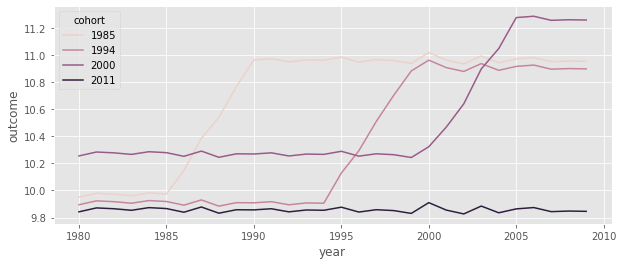

In [8]:
plt.figure(figsize=(10,4))
sns.lineplot(
    data=df_trend_effect.groupby(["cohort", "year"])["outcome"].mean().reset_index(),
    x="year",
    y = "outcome",
    hue="cohort",
);

In [9]:
formula = f"""outcome ~ treat:post + C(year) + C(unit)""" 

mod = smf.ols(formula, data=df_trend_effect)

result = mod.fit()

result.params["treat:post"]

0.6505372592799239

In [10]:
df_trend_effect.query("treat==1 & post==1")["tau"].mean()

0.8293413173652695

### Event Study Desing

In [11]:
relative_years = range(-10,10+1)

formula = "outcome~"+"+".join([f'Q({c})' for c in relative_years]) + "+C(unit)+C(year)"

mod = smf.ols(formula,
              data=(df_trend_effect.join(pd.get_dummies(df_trend_effect["relative_year"]))))

result = mod.fit()

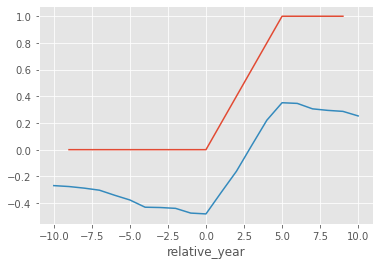

In [12]:
ax = (df_trend_effect
      .query("treat==1")
      .query("relative_year>-10")
      .query("relative_year<10")
      .groupby("relative_year")["tau"].mean().plot())

ax.plot(relative_years, result.params[-len(relative_years):]);

## Covariates

## X-Specific Trends

In [13]:
time = range(1980, 2000)
cohorts = [1990]
units = range(1, 100+1)

np.random.seed(3)

x = np.random.choice(np.random.normal(size=len(units)//10), size=len(units))

df_cov_trend = pd.DataFrame(dict(
    year = np.tile(time, len(units)),
    unit = np.repeat(units, len(time)),
    cohort = np.repeat(np.random.choice(cohorts, len(units)), len(time)),
    unit_fe = np.repeat(np.random.normal(size=len(units)), len(time)),
    time_fe = np.tile(np.random.normal(size=len(time)), len(units)),
    x = np.repeat(x, len(time)),
)).assign(
    trend = lambda d: d["x"]*(d["year"] - d["year"].min())/20,
    post = lambda d: (d["year"] >= d["cohort"]).astype(int),
).assign(
    treat = np.repeat(np.random.binomial(1, expit(x)), len(time)),
    y0 = lambda d: 10 + d["trend"] + 0.5*d["unit_fe"] + 0.01*d["time_fe"],
).assign(
    y1 = lambda d: d["y0"] + 1
).assign(
    tau = lambda d: d["y1"] - d["y0"],
    outcome = lambda d: np.where(d["treat"]*d["post"] == 1, d["y1"], d["y0"])
)

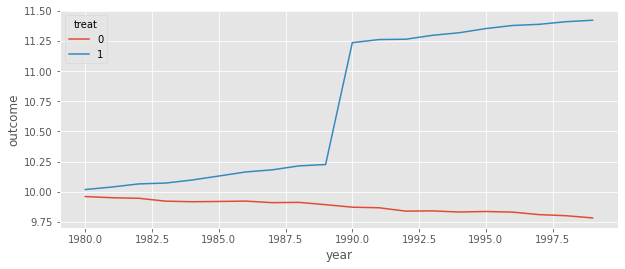

In [14]:
plt.figure(figsize=(10,4))
sns.lineplot(
    data=df_cov_trend.groupby(["treat", "year"])["outcome"].mean().reset_index(),
    x="year",
    y = "outcome",
    hue="treat",
);

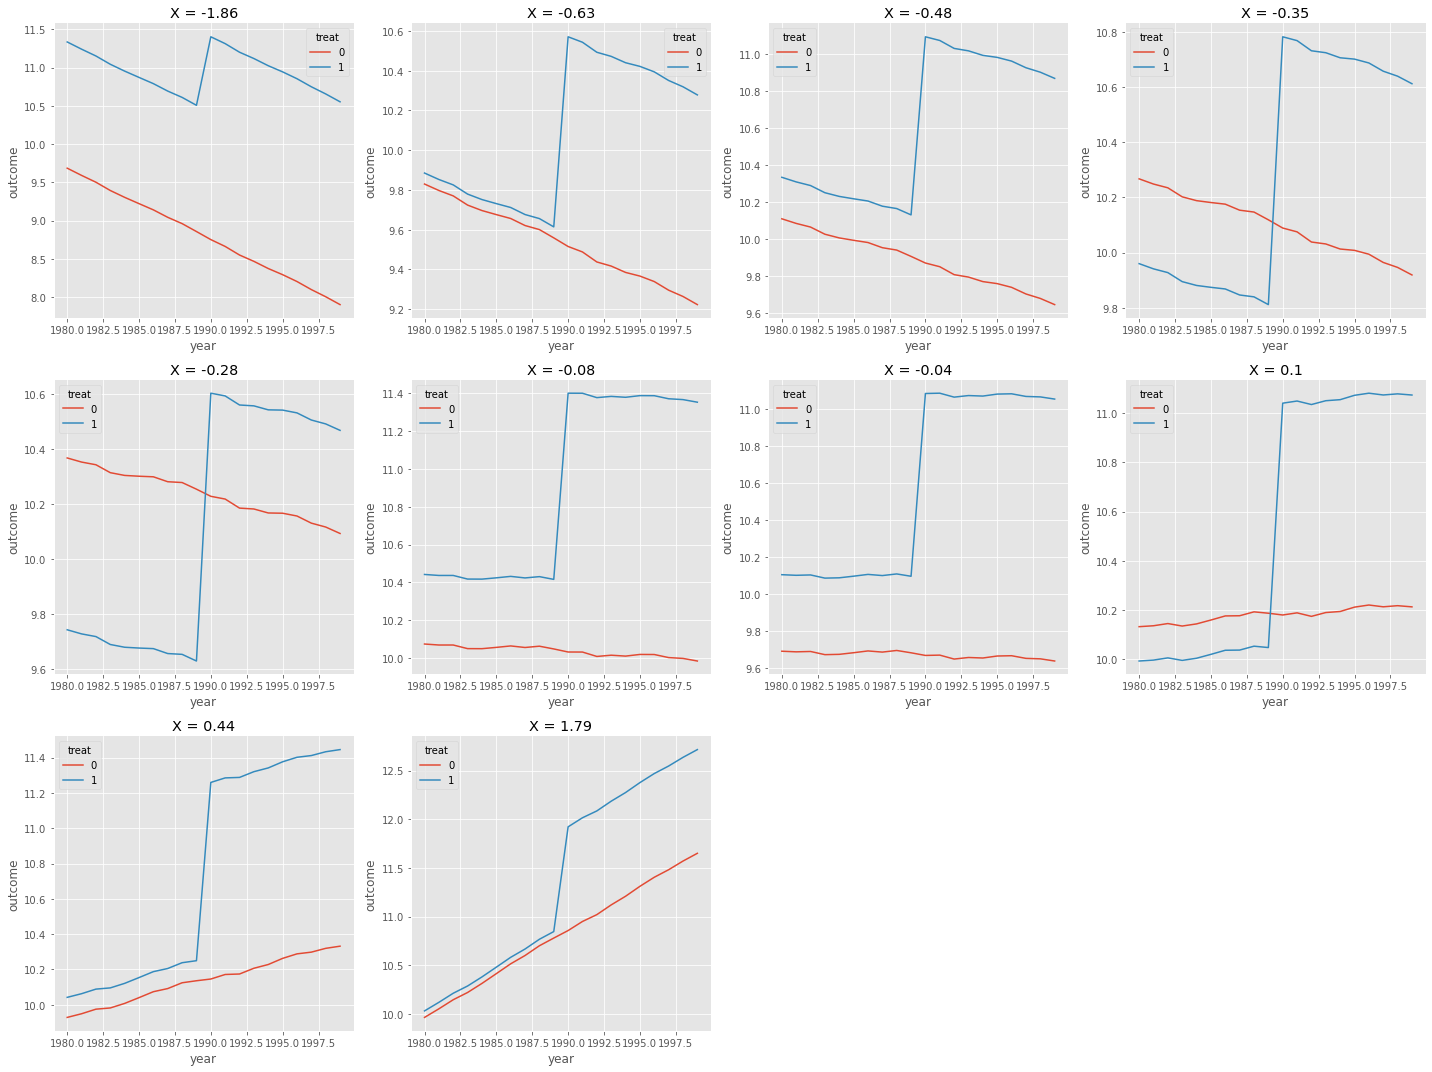

In [15]:
facet_col = "x"
all_facet_values = sorted(df_cov_trend[facet_col].unique())
g = sns.FacetGrid(df_cov_trend, col=facet_col, sharey=False, sharex=False, col_wrap=4, height=5, aspect=1)

for x, ax in zip(all_facet_values, g.axes):
    
    plot_df = df_cov_trend.query(f"{facet_col}=={x}")
    
    sns.lineplot(
        data=plot_df.groupby(["treat", "year"])["outcome"].mean().reset_index(),
        x="year",
        y = "outcome",
        hue="treat",
        ax=ax
    )
    
    ax.set_title(f"X = {round(x, 2)}")    

plt.tight_layout()

In [22]:
formula = f"""outcome ~ treat:post + C(year) + C(unit)""" 

mod = smf.ols(formula, data=df_cov_trend)

result = mod.fit()

result.params["treat:post"]

1.3052744446732731

In [23]:
formula = f"""outcome ~ treat:post + x * C(year) + C(unit)""" 

mod = smf.ols(formula, data=df_cov_trend)

result = mod.fit()

result.params["treat:post"]

0.9999999999999993

In [24]:
df_cov_trend.query("treat==1 & post==1")["tau"].mean()

1.0